In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from collections import Counter
plt.rcParams['figure.figsize'] = (10.0, 10.0)


In [ ]:
# Read the tags data
tags_csv = "https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Tags.csv"
df_tags = pd.read_csv(tags_csv)

# convert Tag to string
df_tags['Tag'] = df_tags['Tag'].astype(str)
# Rename the header name
df_tags = df_tags.rename(columns={'Id': 'ParentId'})
df_tags["ParentId"].astype(int)
print(df_tags.head(10))

   ParentId                    Tag
0        80                   flex
1        80         actionscript-3
2        80                    air
3        90                    svn
4        90            tortoisesvn
5        90                 branch
6        90  branching-and-merging
7       120                    sql
8       120                asp.net
9       120                sitemap


In [ ]:
# Read answer data
ans_csv = "https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Answers.csv"
df_ans = pd.read_csv(ans_csv, header=None, nrows=10000)


In [ ]:
df_ans.shape
df_ans = df_ans.dropna()
df_ans.columns = ["Id", "OwnerUserId", "CreationDate", "ParentId", "Score", "Body"]
df_ans["ParentId"] = pd.to_numeric(df_ans["ParentId"], errors="coerce")
df_ans = df_ans.drop_duplicates(subset = ["OwnerUserId"])
df_ans["OwnerUserId"] = pd.to_numeric(df_ans["OwnerUserId"], errors="coerce")

In [ ]:
# Read the questions data
questions_csv = "https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Questions.csv"
df_questions =  pd.read_csv(questions_csv, header=None, nrows=10000)
df_questions = df_questions.dropna()
df_questions.columns = ["Id", "OwnerUserId", "CreationDate", "ClosedDate", "Score", "Title", "Body"]

In [ ]:
# chunksize = 100000
# tfr = pd.read_csv(questions_csv, chunksize=chunksize, iterator=True,header=None)
# # df_ques = pd.concat(tfr, ignore_index=True)
# tfr.head()

In [ ]:
# first, drop columns where 'date' contains 'nan' (case-insensitive):
df_questions.dropna()
df_questions = df_questions.loc[~df_questions['CreationDate'].str.contains('nan', case=False)]

# convert to datetime, if year is too low, will result in NaT:
df_questions['CreationDate'] = pd.to_datetime(df_questions['CreationDate'], errors='coerce')

In [ ]:
# # first, drop columns where 'date' contains 'nan' (case-insensitive):
# df_questions = df_questions.loc[~df_questions['ClosedDate'].str.contains('nan', case=False)]

# # convert to datetime, if year is too low, will result in NaT:
# df_questions['ClosedDate'] = pd.to_datetime(df_questions['ClosedDate'], errors='coerce')

In [ ]:
df_questions = df_questions.loc[~df_questions['ClosedDate'].str.contains('nan', case=False)]

# convert to datetime, if year is too low, will result in NaT:
df_questions['ClosedDate'] = pd.to_datetime(df_questions['ClosedDate'], errors='coerce')

In [ ]:
# Inner join answers and tags csv
answers = pd.merge(df_tags, df_ans, 
                   on='ParentId', 
                   how='left')

In [ ]:
# Read the users data
users_csv = "https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Users.csv"
df_users = pd.read_csv(users_csv)
df_users = df_users.dropna()
# Drop unwated columns
# df_users.drop(columns=['creation_date', 'last_access_date', 'views', 'up_votes', 'down_votes', 'question is voted up', 'answer is voted up', 'suggested edit is accepted'],inplace=True)
# Remove duplicate entries
df_users = df_users.drop_duplicates(subset = ["display_name", "id"])
df_users = df_users[~(df_users['display_name'].isnull())]
df_users['display_name'] = df_users['display_name'].astype(str)
df_users = df_users.rename(columns={'id': 'OwnerUserId'})
print(df_users.OwnerUserId.dtype)

int64


In [ ]:
df_users.drop(columns=['creation_date', 'last_access_date', 'views', 'up_votes', 'down_votes'],inplace=True)

In [ ]:
# Inner join answers and useres csv
answers = answers.join(df_users, on='OwnerUserId', how='inner', lsuffix='_left', rsuffix='_right')

In [ ]:
answers.columns

Index(['OwnerUserId', 'ParentId', 'Tag', 'Id', 'OwnerUserId_left',
       'CreationDate', 'Score', 'Body', 'Unnamed: 0', 'OwnerUserId_right',
       'display_name', 'reputation'],
      dtype='object')

In [ ]:

# commonly used tags
tags = list(df_tags['Tag'])
all_tags = []
for tag in tqdm_notebook(tags):
    all_tags += tag.split(',')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


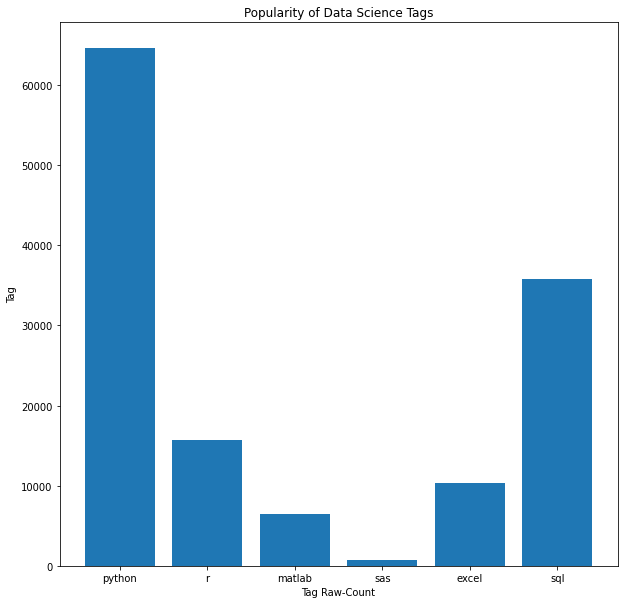

In [ ]:
count_tags = Counter(all_tags)
tags = pd.DataFrame([list(count_tags.keys()), list(count_tags.values())])
tags = tags.transpose()
tags.columns = ['tag', 'count']
tags = tags.sort_values(by='count', ascending=False)

data_science = ['python', 'r', 'matlab', 'sas', 'excel', 'sql']
x = []
y = []

for tag in data_science:
    index = list(tags['tag']).index(tag)
    x.append(tag)
    y.append(list(tags['count'])[index])


plt.bar(x, y)
plt.ylabel('Tag')
plt.xlabel('Tag Raw-Count')
plt.title('Popularity of Data Science Tags')
plt.show()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:

# Filter required tags
# required_tags = df_tags.loc[df_tags['Tag'].isin(['python', 'r', 'matlab', 'sas', 'excel', 'sql'])]

def get_question_ids_by_tags(tag_list):
  filter_tags = answers[answers['Tag'].isin(tag_list)]
  return set(answers['ParentId'].tolist())

def get_questionid_by_title(title):
  filtered_data = df_questions[df_questions['Title'] == title]
  return filtered_data['OwnerUserId']

def get_tag_by_question_id(id):
  filter_tags = answers[answers['ParentId'] == id]
  return filter_tags['Tag'].tolist()

def get_username_list_by_tag(id_list):
  filter_user_names = df_users[df_users['OwnerUserId'].isin(id_list)]
  return filter_user_names['display_name'].tolist()

def get_question_ids_by_tag(tag):
  filtered_data = df_tags[df_tags['Tag'] == tag]
  return filtered_data['ParentId'].tolist()

def get_data_by_question_ids(id_list):
  filtered_data = df_questions[df_questions['Id'].isin(id_list)]
  return filtered_data


In [ ]:
df_questions.Title

0                                                   Title
2       Good branching and merging tutorials for Torto...
7                   Homegrown consumption of web services
28                            Good STL-like library for C
30             What are your favorite Powershell Cmdlets?
                              ...                        
9824    strange linq to nhibernate issue, Invalid cast...
9857    Looking for a Command Line Argument Parser for...
9899     What is the best implementation for AOP in .Net?
9900                         Converting HTML files to PDF
9969                   Best UI Library to use with jQuery
Name: Title, Length: 586, dtype: object

In [ ]:
df_questions.Id

0           Id
2           90
7          470
28        2540
30        2630
         ...  
9824    629480
9857    631410
9899    633710
9900    633780
9969    636910
Name: Id, Length: 586, dtype: object

In [ ]:
get_questionid_by_title('Good STL-like library for C')

28    136
Name: OwnerUserId, dtype: object

In [ ]:
id_list = get_question_ids_by_tags(["python"])
id_list

In [ ]:
id_list = get_tag_by_question_id(112010)
id_list

['mysql', 'innodb']

In [ ]:
# Task 1 - When a user raises a question with a data science tag ('python', 'r', 'matlab', 'sas', 'excel', 'sql'), 
#Stack Overflow sends the notification to the relevant users.
get_username_list_by_tag(id_list)

['Tim Saunders',
 'Gratzy',
 'brasskazoo',
 'Evan Teran',
 'superlogical',
 'aemkei',
 'jpencola',
 'wunki',
 'squelart',
 'Matthew Frederick',
 'Rob Murdoch',
 'Nikola SmiljaniÄ\x87',
 'Alex James',
 'Milan',
 'arbiter',
 'jW.',
 'mczepiel',
 'james2m',
 'Steve',
 'Rich Dougherty',
 'Shaun Rowan',
 'Bryan Head',
 'ruipacheco',
 'Hibiscus',
 'Matt Dressel']

In [ ]:
# When a user provides a data science tag ('python', 'r', 'matlab', 'sas', 'excel', 'sql') to their question, 
# Stack Overflow should come up with the expected approximate time to get it answered.
get_question_ids_by_tag('python')

In [ ]:
data = get_data_by_question_ids(["2540"])
data['duration'] = data.ClosedDate.max() - data.CreationDate.max()
data.duration.mean()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Timedelta('2066 days 23:05:51')

In [ ]:
data.ClosedDate


28   2014-04-03 15:36:28+00:00
Name: ClosedDate, dtype: datetime64[ns, UTC]

In [ ]:
data.CreationDate

28   2008-08-05 16:30:37+00:00
Name: CreationDate, dtype: datetime64[ns, UTC]